# **Pathfinding Intelligence:**  *Dynamic Programming, Monte Carlo, and Temporal Difference Learning in Action*
---

This notebook demonstrates the implementation of three Reinforcement Learning
algorithms (Dynamic Programming, Monte Carlo, and Temporal Difference) for solving
a maze navigation problem.

## **Objective:**

* To implement and compare the performance of different RL algorithms in a controlled
  maze environment.
* To gain practical experience in applying RL concepts to a real-world problem.

## **Aim:**

To develop and analyze RL agents that can effectively learn optimal policies for navigating
a given maze environment, maximizing the cumulative reward.

---

## **1. Introduction**

Reinforcement Learning (RL) is a powerful paradigm for training agents to interact with
an environment and learn optimal behaviors. In this project, we focus on solving a
classic maze navigation problem using three prominent RL algorithms:

* **Dynamic Programming (DP):** Leverages knowledge of the entire environment to
  iteratively compute the optimal policy.
* **Monte Carlo (MC) Learning:** Learns from complete episodes of interaction with
  the environment.
* **Temporal Difference (TD) Learning:** Learns from incomplete episodes and
  bootstraps from current estimates.

This notebook provides a comprehensive implementation and analysis of these
algorithms, along with visualizations and performance comparisons.

---


In [37]:
import numpy as np
import random
import matplotlib.pyplot as plt

## **2. Maze Environment**
---


In [38]:
# 2. Maze Environment

class Maze:
    """
    Defines the maze environment with obstacles, starting locations,
    absorbing states (goal locations), and rewards.
    """

    def __init__(self):
        """
        Initializes the maze environment.
        """
        # Properties set from the CID
        cid = get_CID()
        y = int(cid[-2])
        z = int(cid[-1])
        self._prob_success = 0.8 + 0.02 * (9 - y)  # float
        self._gamma = 0.8 + 0.02 * y  # float
        self._goal = 3  # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3) z%4

        # Build the maze
        self._build_maze()

        self._graphics_object = GraphicsMaze(self._shape,
                                        self._locations,
                                        self._default_reward,
                                        self._obstacle_locs,
                                        self._absorbing_locs,
                                        self._absorbing_rewards,
                                        self._absorbing)

    def _build_maze(self):
        """
        Maze initialization.
        """

        # Properties of the maze
        self._shape = (13, 10)
        self._obstacle_locs = [
            (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 7), (1, 8), (1, 9),
            (2, 1), (2, 2), (2, 3), (2, 7),
            (3, 1), (3, 2), (3, 3), (3, 7),
            (4, 1), (4, 7),
            (5, 1), (5, 7),
            (6, 5), (6, 6), (6, 7),
            (8, 0),
            (9, 0), (9, 1), (9, 2), (9, 6), (9, 7), (9, 8), (9, 9),
            (10, 0)
        ]  # Location of obstacles
        self._absorbing_locs = [(2, 0), (2, 9), (10, 1), (12, 9)]  # Location of absorbing states
        self._absorbing_rewards = [(500 if (i == self._goal) else -50) for i in range(4)]  # Reward of absorbing states
        self._starting_locs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9)]
        self._default_reward = -1  # Reward for each action performs in the environment
        self._max_t = 500  # Max number of steps in the environment

        # Actions
        self._action_size = 4
        self._direction_names = ['N', 'E', 'S', 'W']  # Direction 0 is 'N', 1 is 'E' and so on

        # States
        self._locations = []
        for i in range(self._shape[0]):
            for j in range(self._shape[1]):
                loc = (i, j)
                # Adding the state to locations if it is no obstacle
                if self._is_location(loc):
                    self._locations.append(loc)
        self._state_size = len(self._locations)

        # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
        self._neighbours = np.zeros((self._state_size, 4))

        for state in range(self._state_size):
            loc = self._get_loc_from_state(state)

            # North
            neighbour = (loc[0] - 1, loc[1])  # North neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
            else:  # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('N')] = state

            # East
            neighbour = (loc[0], loc[1] + 1)  # East neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
            else:  # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('E')] = state

            # South
            neighbour = (loc[0] + 1, loc[1])  # South neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
            else:  # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('S')] = state

            # West
            neighbour = (loc[0], loc[1] - 1)  # West neighbours location
            if self._is_location(neighbour):
                self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
            else:  # If there is no neighbour in this direction, coming back to current state
                self._neighbours[state][self._direction_names.index('W')] = state

        # Absorbing
        self._absorbing = np.zeros((1, self._state_size))
        for a in self._absorbing_locs:
            absorbing_state = self._get_state_from_loc(a)
            self._absorbing[0, absorbing_state] = 1

        # Transition matrix
        self._T = np.zeros((self._state_size, self._state_size, self._action_size))  # Empty matrix of domension S*S*A
        for action in range(self._action_size):
            for outcome in range(4):  # For each direction (N, E, S, W)
                # The agent has prob_success probability to go in the correct direction
                if action == outcome:
                    prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0)  # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
                # Equal probability to go into one of the other directions
                else:
                    prob = (1.0 - self._prob_success) / 3.0

                # Write this probability in the transition matrix
                for prior_state in range(self._state_size):
                    # If absorbing state, probability of 0 to go to any other states
                    if not self._absorbing[0, prior_state]:
                        post_state = self._neighbours[prior_state, outcome]  # Post state number
                        post_state = int(post_state)  # Transform in integer to avoid error
                        self._T[prior_state, post_state, action] += prob

        # Reward matrix
        self._R = np.ones((self._state_size, self._state_size, self._action_size))  # Matrix filled with 1
        self._R = self._default_reward * self._R  # Set default_reward everywhere
        for i in range(len(self._absorbing_rewards)):  # Set absorbing states rewards
            post_state = self._get_state_from_loc(self._absorbing_locs[i])
            self._R[:, post_state, :] = self._absorbing_rewards[i]

        # Creating the graphical Maze world
        self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)

        # Reset the environment
        self.reset()

    def _is_location(self, loc):
        """
        Is the location a valid state (not out of Maze and not an obstacle)
        input: loc {tuple} -- location of the state
        output: _ {bool} -- is the location a valid state
        """
        if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0] - 1 or loc[1] > self._shape[1] - 1):
            return False
        elif (loc in self._obstacle_locs):
            return False
        else:
            return True

    def _get_state_from_loc(self, loc):
        """
        Get the state number corresponding to a given location
        input: loc {tuple} -- location of the state
        output: index {int} -- corresponding state number
        """
        return self._locations.index(tuple(loc))

    def _get_loc_from_state(self, state):
        """
        Get the state number corresponding to a given location
        input: index {int} -- state number
        output: loc {tuple} -- corresponding location
        """
        return self._locations[state]

    # Getter functions used only for DP agents
    # You DO NOT NEED to modify them
    def get_T(self):
        return self._T

    def get_R(self):
        return self._R

    def get_absorbing(self):
        return self._absorbing

    # Getter functions used for DP, MC and TD agents
    # You DO NOT NEED to modify them
    def get_graphics(self):
        return self._graphics_object

    def get_action_size(self):
        return self._action_size

    def get_state_size(self):
        return self._state_size

    def get_gamma(self):
        return self._gamma

    # Functions used to perform episodes in the Maze environment
    def reset(self):
        """
        Reset the environment state to one of the possible starting states
        input: /
        output:
            - t {int} -- current timestep
            - state {int} -- current state of the envionment
            - reward {int} -- current reward
            - done {bool} -- True if reach a terminal state / 0 otherwise
        """
        self._t = 0
        self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
        self._reward = 0
        self._done = False
        return self._t, self._state, self._reward, self._done

    def step(self, action):
        """
        Perform an action in the environment
        input: action {int} -- action to perform
        output:
            - t {int} -- current timestep
            - state {int} -- current state of the envionment
            - reward {int} -- current reward
            - done {bool} -- True if reach a terminal state / 0 otherwise
        """

        # If environment already finished, print an error
        if self._done or self._absorbing[0, self._state]:
            print("Please reset the environment")
            return self._t, self._state, self._reward, self._done

        # Drawing a random number used for probaility of next state
        probability_success = random.uniform(0, 1)

        # Look for the first possible next states (so get a reachable state even if probability_success = 0)
        new_state = 0
        while self._T[self._state, new_state, action] == 0:
            new_state += 1
        assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

        # Find the first state for which probability of occurence matches the random value
        total_probability = self._T[self._state, new_state, action]
        while (total_probability < probability_success) and (new_state < self._state_size - 1):
            new_state += 1
            total_probability += self._T[self._state, new_state, action]
        assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."

        # Setting new t, state, reward and done
        self._t += 1
        self._reward = self._R[self._state, new_state, action]
        self._done = self._absorbing[0, new_state] or self._t > self._max_t
        self._state = new_state
        return self._t, self._state, self._reward, self._done




## **3. Visualization**

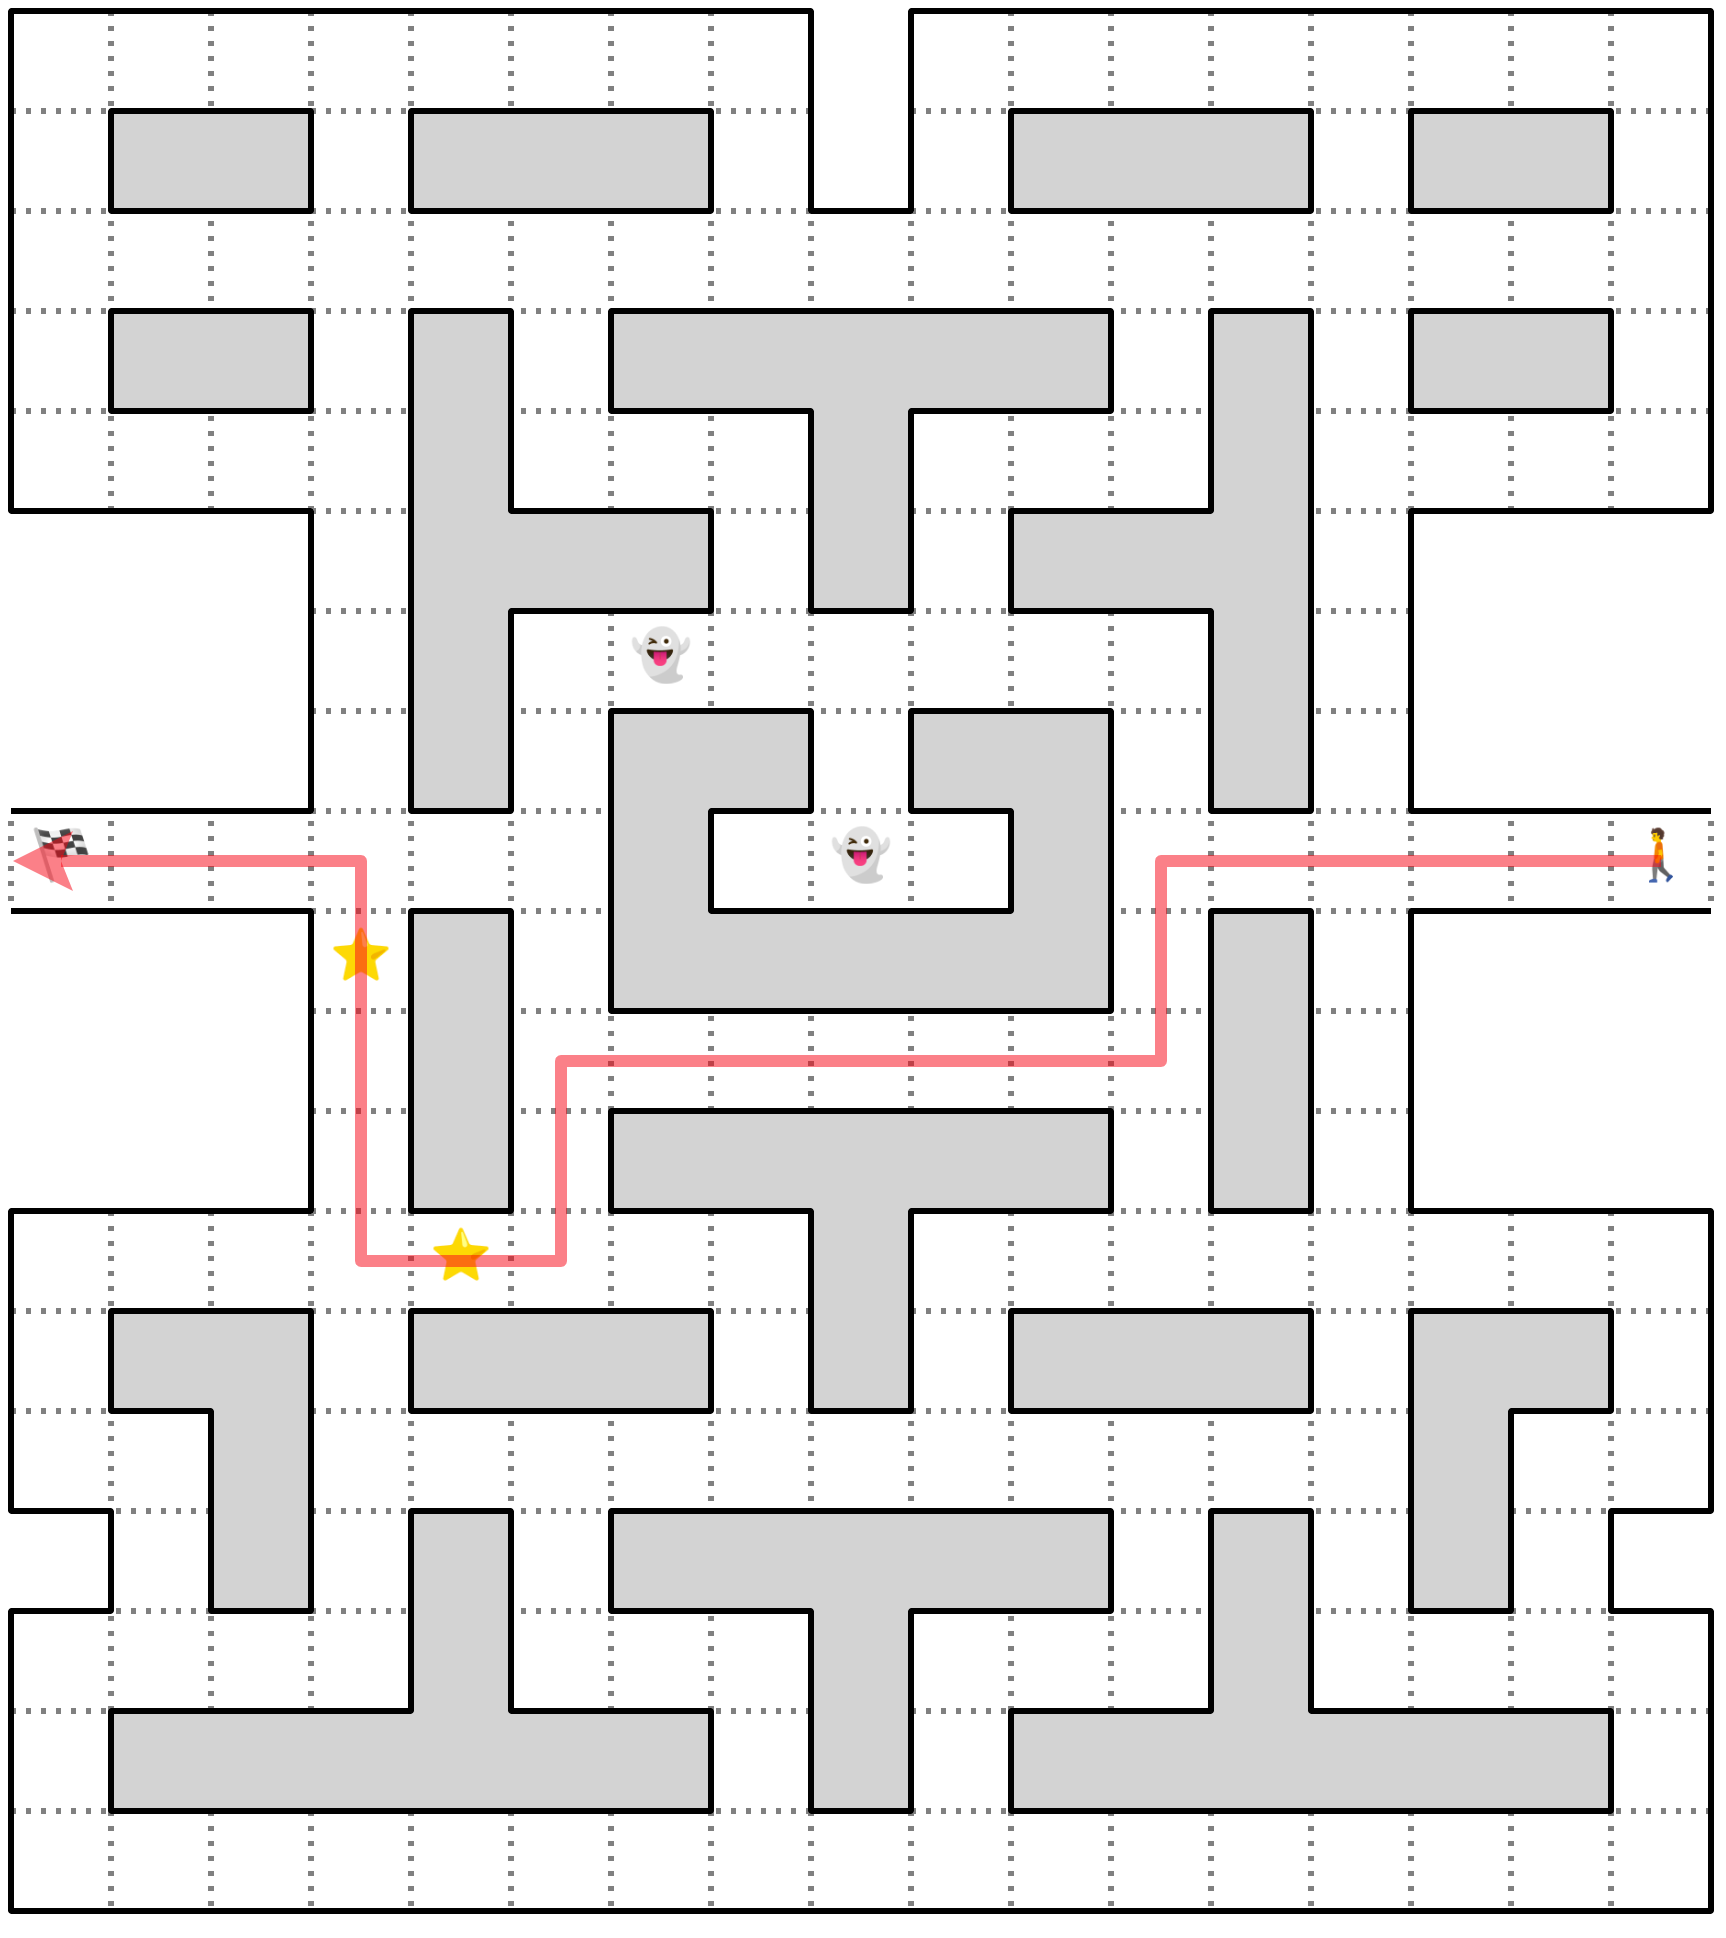

---

In [39]:
# 3. Helper Class for Visualization

class GraphicsMaze:
    """
    A helper class for visualizing the maze environment.
    """

    def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):
        """
        Initializes the GraphicsMaze object.
        """
        self.shape = shape
        self.locations = locations
        self.absorbing = absorbing

        # Walls
        self.walls = np.zeros(self.shape)
        for ob in obstacle_locs:
            self.walls[ob] = 20

        # Rewards
        self.rewarders = np.ones(self.shape) * default_reward
        for i, rew in enumerate(absorbing_locs):
            self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

        # Print the map to show it
        self.paint_maps()

    def paint_maps(self):
        """
        Print the Maze topology (obstacles, absorbing states and rewards)
        input: /
        output: /
        """
        plt.figure(figsize=(15, 10))
        plt.imshow(self.walls + self.rewarders)
        plt.show()

    def paint_state(self, state):
        """
        Print one state on the Maze topology (obstacles, absorbing states and rewards)
        input: /
        output: /
        """
        states = np.zeros(self.shape)
        states[state] = 30
        plt.figure(figsize=(15, 10))
        plt.imshow(self.walls + self.rewarders + states)
        plt.show()

    def draw_deterministic_policy(self, Policy, state):
        """
        Draw a deterministic policy
        input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
        output: /
        """

        graphics = self.get_graphics()
        plt.figure(figsize=(15, 10))
        plt.imshow(self.walls + self.rewarders)  # Create the graph of the Maze
        for state, action in enumerate(Policy):
            if (self.absorbing[0, state]):  # If it is an absorbing state, don't plot any action
                continue
            arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
            action_arrow = arrows[Policy[state]]  # Choose the arrow based on policy for state

            location = self.locations[state]  # Access location using state
            graphics.text(location[1], location[0], action_arrow, ha='center', va='center')

            graphics.show()
           # plt.text(location[1], location[0], action_arrow, ha='center', va='center')  # Place it on graph
        plt.show()

    def draw_policy(self, Policy):
        """
        Draw a policy (draw an arrow in the most probable direction)
        input: Policy {np.array} -- policy to draw as probability
        output: /
        """
        deterministic_policy = np.array([np.argmax(Policy[row, :]) for row in range(Policy.shape[0])])
        self.draw_deterministic_policy(deterministic_policy)

    def draw_value(self, Value):
        """
        Draw a policy value
        input: Value {np.array} -- policy values to draw
        output: /
        """
        plt.figure(figsize=(15, 10))
        plt.imshow(self.walls + self.rewarders)  # Create the graph of the Maze
        for state, value in enumerate(Value):
            if (self.absorbing[0, state]):  # If it is an absorbing state, don't plot any value
                continue
            location = self.locations[state]  # Compute the value location on graph
            plt.text(location[1], location[0], round(value, 2), ha='center', va='center')  # Place it on graph
        plt.show()

    def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
        """
        Draw a grid representing multiple deterministic policies
        input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
        output: /
        """
        plt.figure(figsize=(20, 8))
        for subplot in range(len(Policies)):  # Go through all policies
            ax = plt.subplot(n_columns, n_lines, subplot + 1)  # Create a subplot for each policy
            ax.imshow(self.walls + self.rewarders)  # Create the graph of the Maze

        for state, action in enumerate(Policy):
          location = self.locations[state]  # Access location using state

        for state, action in enumerate(Policies[subplot]):
                if (self.absorbing[0, state]):  # If it is an absorbing state, don't plot any action
                    continue
                arrows = [r"$\uparrow$", r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]  # List of arrows corresponding to each possible action
                action_arrow = arrows[action]  # Take the corresponding action
                location = self.locations[state]  # Compute its location on graph
                plt.text(location[1], location[0], action_arrow, ha='center', va='center')  # Place it on graph
                ax.title.set_text(title[subplot])  # Set the title for the graph given as argument
        plt.show()

    def draw_policy_grid(self, Policies, title, n_columns, n_lines):
        """
        Draw a grid representing multiple policies (draw an arrow in the most probable direction)
        input: Policy {np.array} -- array of policies to draw as probability
        output: /
        """
        deterministic_policies = np.array([[np.argmax(Policy[row, :]) for row in range(Policy.shape[0])] for Policy in Policies])
        self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

    def draw_value_grid(self, Values, title, n_columns, n_lines):
        """
        Draw a grid representing multiple policy values
        input: Values {np.array of np.array} -- array of policy values to draw
        output: /
        """
        plt.figure(figsize=(20, 8))
        for subplot in range(len(Values)):  # Go through all values
            ax = plt.subplot(n_columns, n_lines, subplot + 1)  # Create a subplot for each value
            ax.imshow(self.walls + self.rewarders)  # Create the graph of the Maze
            for state, value in enumerate(Values[subplot]):
                if (self.absorbing[0, state]):  # If it is an absorbing state, don't plot any value
                    continue
                location = self.locations[state]  # Compute the value location on graph
                plt.text(location[1], location[0], round(value, 1), ha='center', va='center')  # Place it on graph
            ax.title.set_text(title[subplot])  # Set the title for the graoh given as argument
        plt.show()


##**Dynamic Programming**

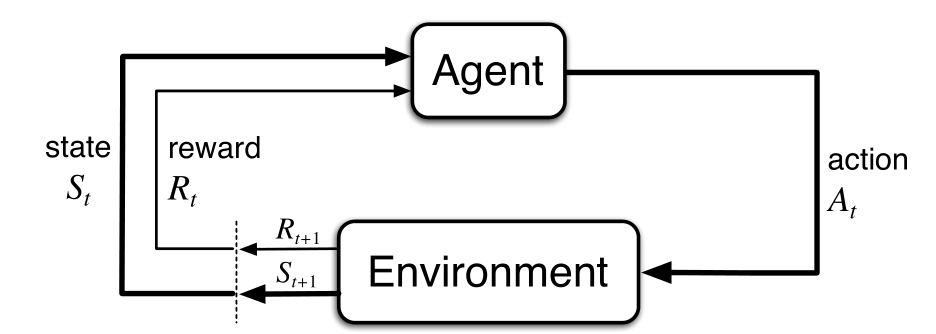

---

In [45]:
# 4. Dynamic Programming Agent

class DP_agent:
    """
    Implements the Dynamic Programming algorithm for solving the maze.
    """

    def solve(self, env):
        """
        Solves the given maze environment using Dynamic Programming.

        Args:
            env (Maze): The Maze environment object.

        Returns:
            tuple: A tuple containing the optimal policy and the corresponding
                   value function.
        """
        # Initialisation (can be edited)
        policy = np.zeros((env.get_state_size(), env.get_action_size()))
        V = np.zeros(env.get_state_size())

        ####
        # Add your code here
        # WARNING: for this agent only, you are allowed to access env.get_T(), env.get_R() and env.get_absorbing()
        ####

        #### Here we are accessing the environment properties ####
        # T: Transition matrix
        # R: Reward matrix
        # absorbing: Boolean array indicating absorbing states in the environment
        # actions: Total number of possible actions
        # states: Total number of possible states
        # gamma: Discount factor

        T = env.get_T()
        R = env.get_R()
        absorbing = env.get_absorbing()
        actions = env.get_action_size()
        states = env.get_state_size()
        gamma = env.get_gamma()

        # Set threshold for convergence of the value function

        threshold = 1

        # Ensure gamma value is valid
        assert (gamma <= 1) and (gamma >= 0), "Discount factor should be in [0, 1]."

        # Initialisation
        epochs = 0
        delta = threshold  # Setting value of delta to go through the first breaking condition
        V = np.zeros(states)  # Initialise values at 0 for each state

        while delta >= threshold:
            epochs += 1  # Increment the epoch
            delta = 0  # Reinitialise delta value

            # For each state
            for prior_state in range(states):

                # If not an absorbing state
                if not absorbing[0, prior_state]:

                    # Store the previous value for that state
                    v = V[prior_state]

                    # Compute Q value
                    Q = np.zeros(4)  # Initialise with value 0
                    for post_state in range(states):
                        Q += T[prior_state, post_state, :] * (R[prior_state, post_state, :] + gamma * V[post_state])

                    # Set the new value to the maximum of Q
                    V[prior_state] = np.max(Q)

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[prior_state]))

        # When the loop is finished, fill in the optimal policy
        policy = np.zeros((states, actions))  # Initialisation

        for prior_state in range(states):
            # Compute the Q value
            Q = np.zeros(4)
            for post_state in range(states):
                Q += T[prior_state, post_state, :] * (R[prior_state, post_state, :] + gamma * V[post_state])

            # The action that maximises the Q value gets probability 1
            policy[prior_state, np.argmax(Q)] = 1

        return policy, V



## **5. Monte Carlo Agent**
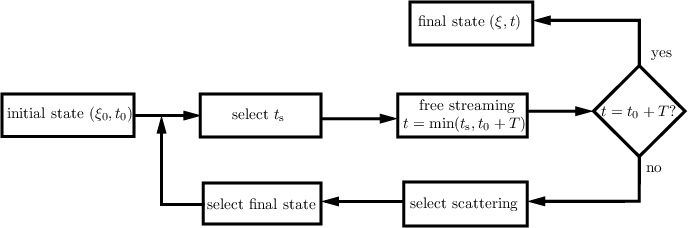

---

In [41]:
# 5. Monte Carlo Agent

class MC_agent:
    """
    Implements the Monte Carlo learning algorithm for solving the maze.
    """

    def solve(self, env):
        """
        Solves the given maze environment using Monte Carlo learning.

        Args:
            env (Maze): The Maze environment object.

        Returns:
            tuple: A tuple containing the optimal policy, a list of successive
                   value functions, and a list of total rewards for each episode.
        """

        # Initialisation (can be edited)
        Q = np.random.rand(env.get_state_size(), env.get_action_size())
        V = np.zeros(env.get_state_size())
        epsilon = 0.01
        states = env.get_state_size()
        actions = env.get_action_size()
        gamma = env.get_gamma()
        policy = np.zeros((env.get_state_size(), env.get_action_size()))

        # Initialize policy based on initial Q values
        policy = initialize_policy(states, actions, Q, policy, epsilon)
        values = [V]
        total_rewards = []

        # env.reset() and env.step() methods of the Maze class, as well as env.get_action_size(),
        # env.get_state_size() and env.get_gamma().

        ####
        # Add your code here
        # WARNING: this agent only has access to env.reset() and env.step()
        # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
        ####

        returns = {}

        # Set the number of episodes to run Monte Carlo algorithm

        num_episodes = 1000
        for iteration in range(num_episodes):

            G = 0  # Initialize return
            episode = generate_episode(env, actions, policy)  # Generate an episode using the current policy
            sum_rewards = 0
            epsilon = epsilon - (epsilon / num_episodes)  # Decay epsilon over time

            for i in reversed(range(0, len(episode))):

                t, s_t, a_t, r_t = episode[i]  # Time step, state, action, reward for current step
                state_action = (s_t, a_t)
                G = gamma * G + r_t  # Increment total reward by reward on current timestep
                sum_rewards += r_t

                # Check if this is the first occurrence of the state-action pair in the episode

                if not state_action in [(x[1], x[2]) for x in episode[0:i]]:  # to check

                    # Update returns for the state-action pair

                    if returns.get(state_action):
                        returns[state_action].append(G)
                    else:
                        returns[state_action] = [G]

                    Q[s_t][a_t] = np.mean(returns[state_action])  # Average reward across episodes

                    Q_list = Q[s_t]
                    indices = np.where(Q_list == np.max(Q_list))[0]  # Get indices of max Q-values
                    max_Q = np.random.choice(indices)

                    A_star = max_Q  # Optimal action for the current state

                    for a in range(actions):  # Update action probability for s_t in policy
                        if a == A_star:
                            policy[s_t][a] = 1 - epsilon + (epsilon / actions)
                        else:
                            policy[s_t][a] = (epsilon / actions)

            # Calculate the value function V based on current policy and Q values

            V = np.sum(policy * Q, axis=1)
            values.append(V.copy())
            total_rewards.append(sum_rewards)  # Store the total rewards for the current episode

        return policy, values, total_rewards

def generate_episode(env, actions, policy):
    """ To generate an episode based on the policy

    Args:
        env (object): The object of the maze class
        actions (int): Total number of possible actions
        policy (np.array): An array of size (number of states x number of actions)

    Returns:
        list: The generated episode
    """

    t, state, reward, done = env.reset()
    episode = []
    while not done:
        action_probs = policy[state]

        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        t, next_state, reward, done = env.step(action)
        episode.append((t, state, action, reward))
        state = next_state

    return episode

def initialize_policy(states, actions, Q, policy, epsilon):
    """ To initialize the policy

    Args:
        states (int): Total number of states
        actions (int): Total number of possible actions
        Q (np.array): An array of state-action value function having size (number of states x number of actions)
        policy (np.array): An array of size (number of states x number of actions)
        epsilon (float): A parameter to choose the action based on a stochastic policy
    Returns:
        np.array: The initialized policy based on epsilon soft policy
    """
    for state in range(states):
        best_action = random.choice(range(actions))
        for action in range(actions):
            if action == best_action:
                policy[state][action] = 1 - epsilon + (epsilon / actions)
            else:
                policy[state][action] = (epsilon / actions)

    return policy


## **6. Temporal Difference Agent**

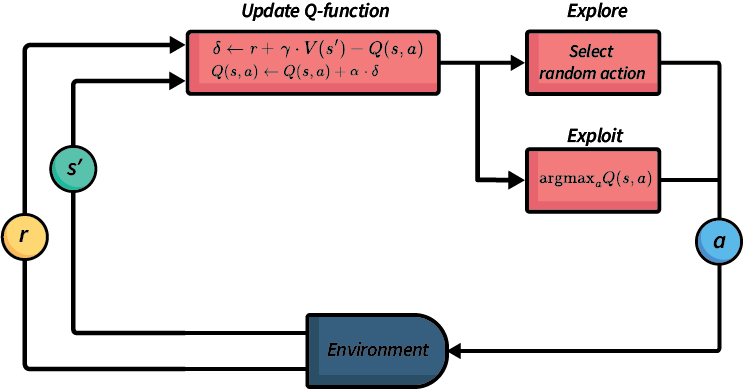

---

In [44]:
# 6. Temporal Difference Agent

class TD_agent:
    """
    Implements the Temporal Difference learning algorithm for solving the maze.
    """

    def solve(self, env):
        """
        Solves the given maze environment using Temporal Difference learning.

        Args:
            env (Maze): The Maze environment object.

        Returns:
            tuple: A tuple containing the optimal policy, a list of successive
                   value functions, and a list of total rewards for each episode.
        """

        # Initialisation (can be edited)
        Q = np.random.rand(env.get_state_size(), env.get_action_size())
        V = np.zeros(env.get_state_size())
        policy = np.zeros((env.get_state_size(), env.get_action_size()))
        values = [V]
        total_rewards = []

        # Get the absorbing states

        absorbing = env.get_absorbing()[0]

        # Set the Q-values for absorbing states to zero

        for ind, state in enumerate(absorbing):
            if state != 0:
                Q[ind, :] = 0

        states = env.get_state_size()
        actions = env.get_action_size()
        gamma = env.get_gamma()

        alpha = 0.1  # 0.1  Although theory says that alpha should follow Robbins-Monro conditions, but in practice it is observed that the SARSA stil converges by using constant aplha - David Silver
        epsilon = 0.4  # 0.4

        n_episodes = 1000  # Total number of episodes to run

        # Initialize the policy based on the initial Q-values

        policy = initialize_policy(states, actions, Q, policy, epsilon)

        for episode in range(n_episodes):

            epsilon = epsilon - (epsilon / n_episodes)  # Implementation of epsilon decay
            t, state, reward, done = env.reset()
            action = epsilon_greedy(state, epsilon, policy, actions)  # Select the first action using epsilon-greedy policy
            reward_sum = 0  # Track the sum of rewards for this episode

            # Loop over each step within the episode until the agent reaches a terminal state

            while not done:

                # Take action and observe the next state, reward, and whether the episode is done

                t, next_state, reward, done = env.step(action)

                alpha = 1 / (t + 1)  # Implement alpha decay

                next_action = epsilon_greedy(next_state, epsilon, policy, actions)  # Select the next action using epsilon-greedy policy

                # Update the Q-value using the SARSA update rule

                Q[state, action] += alpha * (
                        reward + gamma * Q[next_state, next_action] - Q[state, action]
                )

                # Update policy to choose the action with the highest Q-value for the current state

                Q_list = Q[state]
                indices = np.where(Q_list == np.max(Q_list))[0]  # Get indices of max Q-values
                max_Q = np.random.choice(indices)
                A_star = max_Q  # choose the best action

                for a in range(actions):  # Update action probability for s_t in policy
                    if a == A_star:
                        policy[state][a] = 1 - epsilon + (epsilon / actions)
                    else:
                        policy[state][a] = (epsilon / actions)

                # Move to the next state and action

                state = next_state
                action = next_action
                reward_sum += reward

            total_rewards.append(reward_sum)

            # Calculate the value function V based on current policy and Q values

            V = np.sum(policy * Q, axis=1)
            values.append(V.copy())

        return policy, values, total_rewards

def generate_episode(env, actions, policy):
    """ To generate an episode based on the policy

    Args:
        env (object): The object of the maze class
        actions (int): Total number of possible actions
        policy (np.array): An array of size (number of states x number of actions)

    Returns:
        list: The generated episode
    """

    t, state, reward, done = env.reset()
    episode = []
    while not done:
        action_probs = policy[state]

        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        t, next_state, reward, done = env.step(action)
        episode.append((t, state, action, reward))
        state = next_state

    return episode

def initialize_policy(states, actions, Q, policy, epsilon):
    """ To initialize the policy

    Args:
        states (int): Total number of states
        actions (int): Total number of possible actions
        Q (np.array): An array of state-action value function having size (number of states x number of actions)
        policy (np.array): An array of size (number of states x number of actions)
        epsilon (float): A parameter to choose the action based on a stochastic policy
    Returns:
        np.array: The initialized policy based on epsilon soft policy
    """
    for state in range(states):
        best_action = random.choice(range(actions))
        for action in range(actions):
            if action == best_action:
                policy[state][action] = 1 - epsilon + (epsilon / actions)
            else:
                policy[state][action] = (epsilon / actions)

    return policy

##**Driver's Code**

---

Creating the Maze:



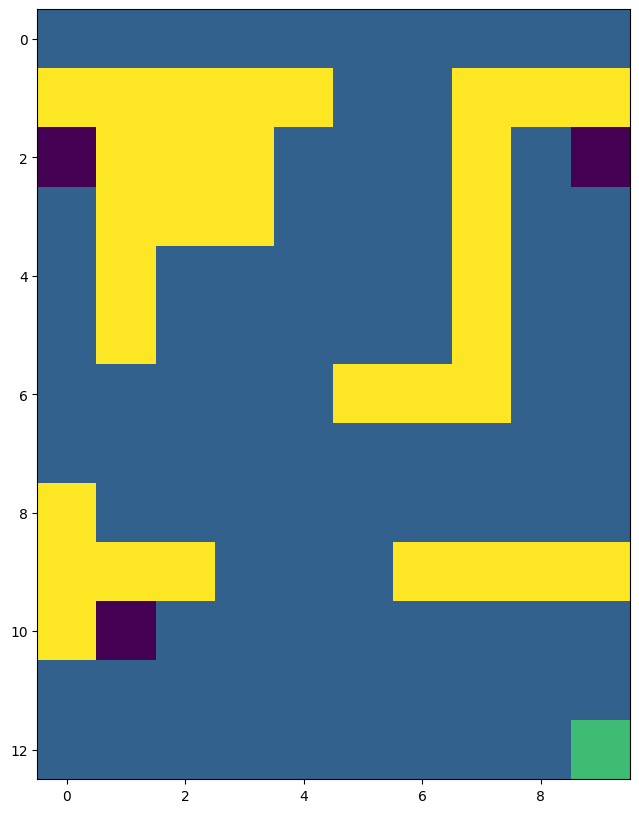

Results of the DP agent:



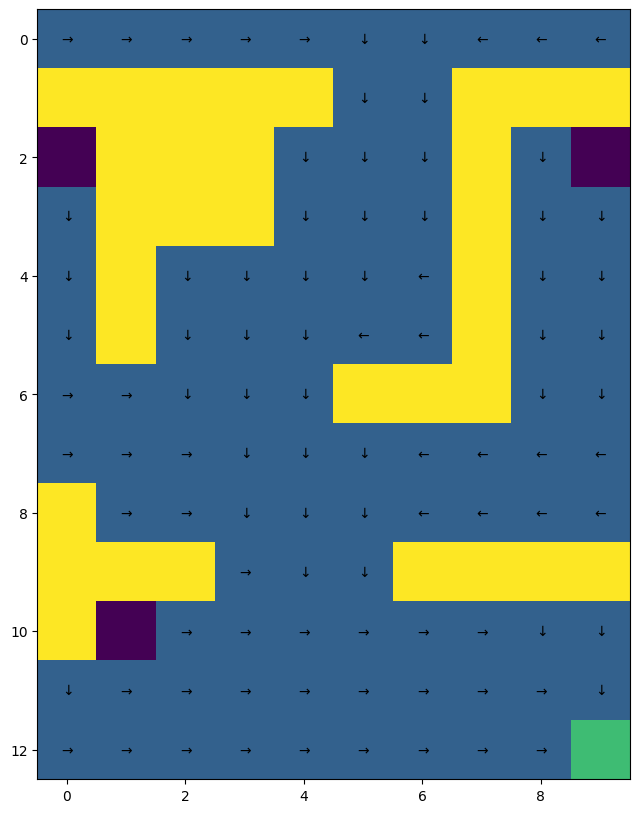

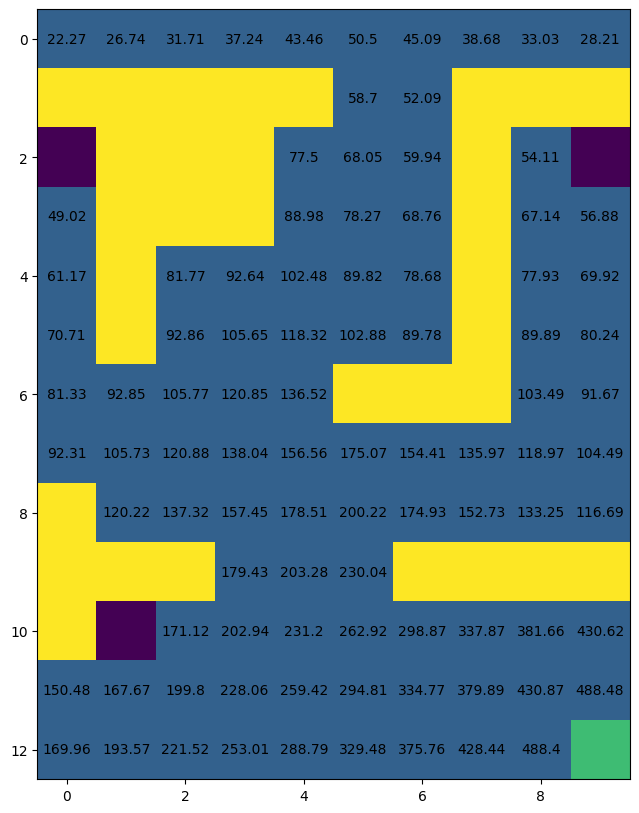

Results of the MC agent:



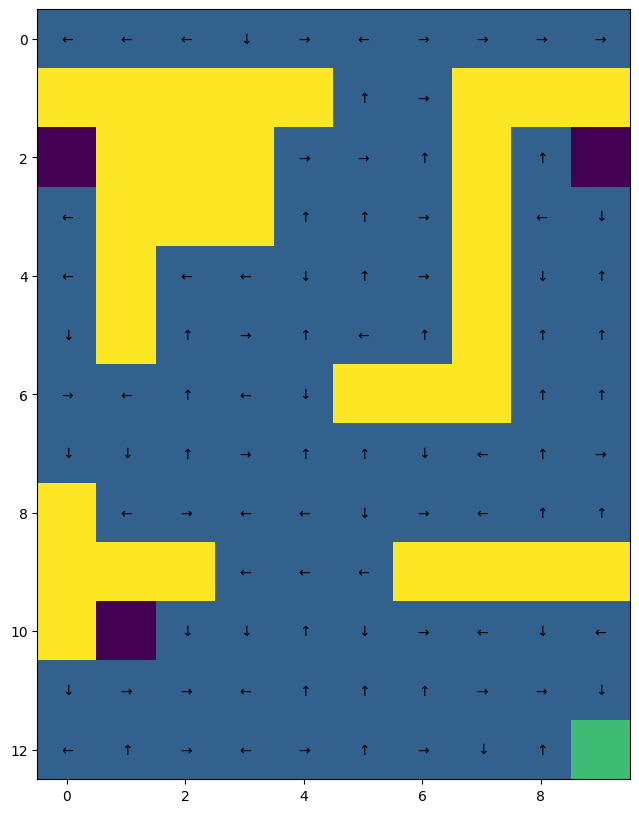

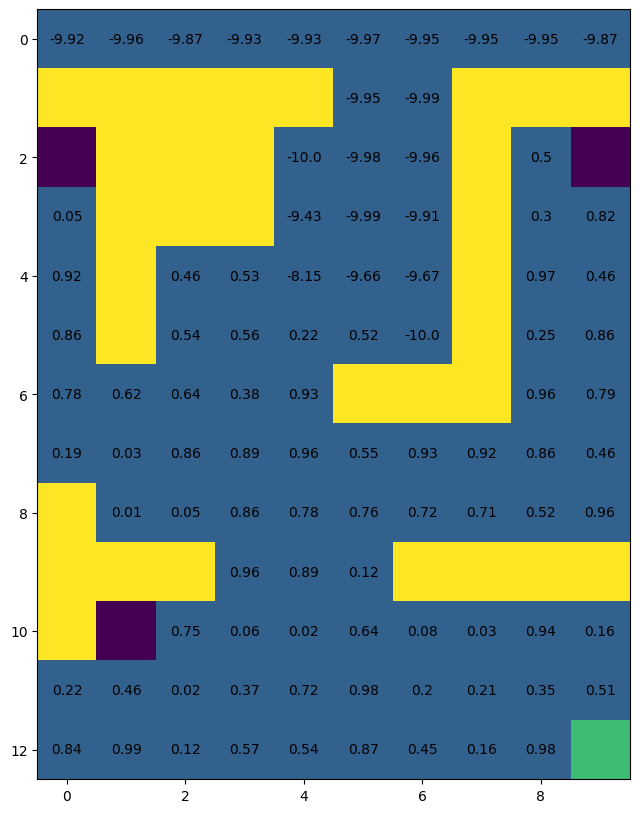

Results of the TD agent:



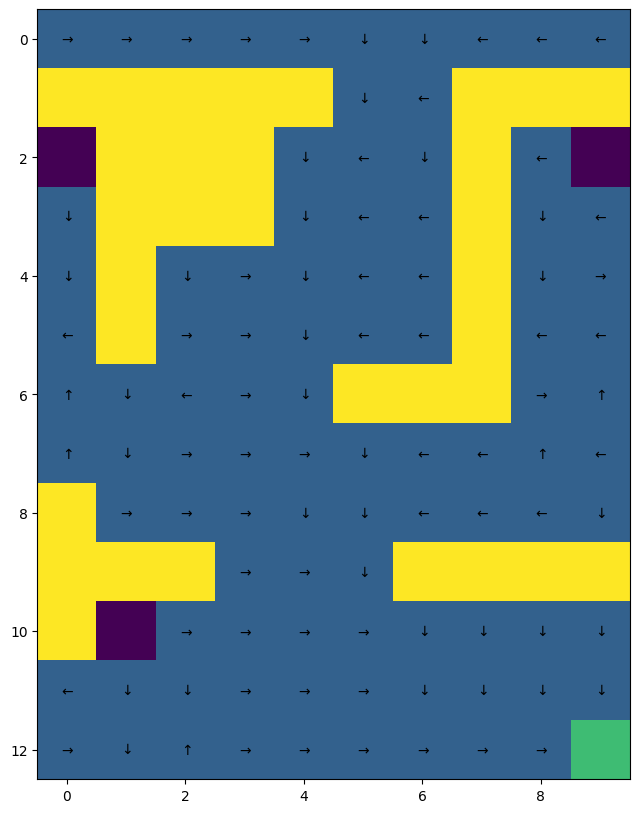

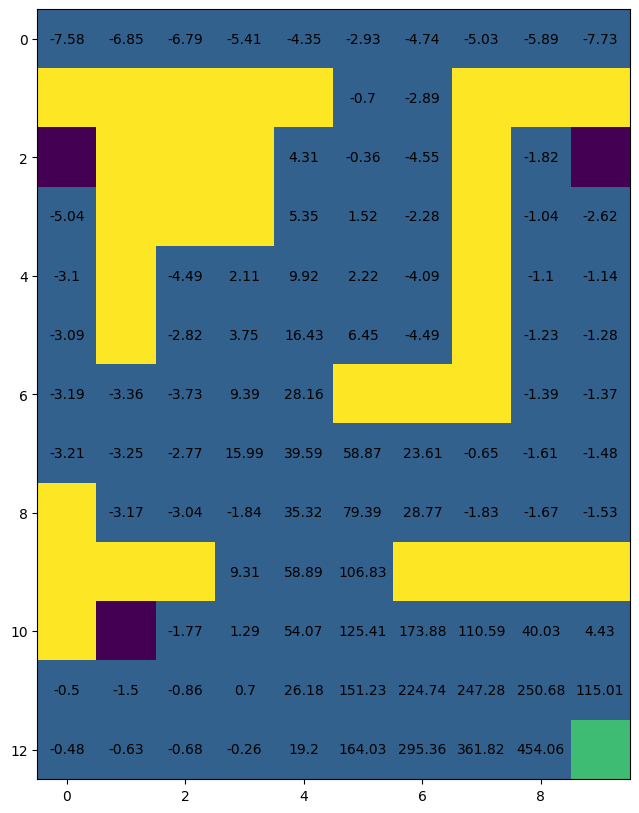

In [36]:
# 7. Main Execution
def get_CID():
      return "06006553"  # Replace with your actual CID

if __name__ == "__main__":

    # Create the maze environment
    print("Creating the Maze:\n")
    maze = Maze()

    # Solve using Dynamic Programming
    dp_agent = DP_agent()
    dp_policy, dp_value = dp_agent.solve(maze)

    print("Results of the DP agent:\n")
    maze.get_graphics().draw_policy(dp_policy, state)  # Pass state argument
    maze.get_graphics().draw_value(dp_value)

    #print("Results of the DP agent:\n")
    #for state in range(len(dp_policy)):
    #  maze.get_graphics().draw_policy(dp_policy, state)  # Pass state as argument
    #maze.get_graphics().draw_value(dp_value)

    # Solve using Monte Carlo learning
    mc_agent = MC_agent()
    mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

    print("Results of the MC agent:\n")
    maze.get_graphics().draw_policy(mc_policy)
    maze.get_graphics().draw_value(mc_values[-1])

    # Solve using Temporal Difference learning
    td_agent = TD_agent()
    td_policy, td_values, total_rewards = td_agent.solve(maze)

    print("Results of the TD agent:\n")
    maze.get_graphics().draw_policy(td_policy)
    maze.get_graphics().draw_value(td_values[-1])


---

##**Key Achievements:**
- **Implementation of Core RL Algorithms:**  
  Successfully implemented Dynamic Programming (DP), Monte Carlo (MC), and Temporal Difference (TD) methods, showcasing foundational RL concepts like policy evaluation, policy improvement, and the balance between exploration and exploitation.  
- **Maze Environment Creation:**  
  Developed a parameterized and flexible maze environment, supporting customization in obstacle placement, reward structures, and agent dynamics. This testbed allows robust evaluation of RL algorithms.  
- **Visualization Enhancements:**  
  Integrated visualization capabilities to graphically depict agent behavior and learning processes, aiding in debugging and analysis of policy effectiveness and exploration strategies.

---

##**Future Work:**

- **Advanced RL Algorithms:**  
  Explore Q-learning, SARSA, Deep Q-Networks (DQN), and Actor-Critic methods to improve performance in dynamic and scalable environments.  
- **Deep Reinforcement Learning (DRL):**  
  Incorporate neural networks for value functions or policy approximations to handle high-dimensional state spaces effectively.  
- **Continuous Action Spaces:**  
  Adapt the framework for continuous action spaces, expanding its applicability to robotics and control systems.  
- **Hierarchical RL:**  
  Implement task decomposition into sub-goals, facilitating faster convergence in complex environments.  
- **Multi-agent Systems:**  
  Introduce scenarios with multiple agents for cooperative and competitive interactions, enabling real-world multi-agent system applications.

---

##**Conclusion:**
This project serves as a stepping stone to understanding and applying reinforcement learning (RL) methods for sequential decision-making tasks. By implementing and analyzing DP, MC, and TD methods, the project highlights their strengths, limitations, and adaptability in maze navigation. Future enhancements, such as incorporating DRL, continuous action spaces, or multi-agent systems, can address current limitations and extend RL applications to more complex and dynamic real-world problems like autonomous driving, robotics, and game AI.

---
---